In [1]:
# import boto3
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
germany_df = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', index_col='LNR')
customers_df = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', index_col='LNR')
train_df = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', index_col='LNR')
test_df = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';', index_col='LNR')
metadata = pd.read_csv('data/metadata.csv')
print(germany_df.shape)

/Users/richard.wuebker/.pyenv/versions/science/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(891221, 365)


In [3]:
metadata.head()

,feature_name,type,unknown_neg_one,unknown_zero,unknown_nine,zero_none,needs_reverse,keep
0,AGER_TYP,ordinal,1,1,0,0,0,1
1,ALTERSKATEGORIE_GROB,ordinal,1,1,1,0,0,1
2,ALTER_HH,ordinal,0,1,0,0,0,1
3,ANREDE_KZ,categorical,1,1,0,0,0,1
4,ANZ_HAUSHALTE_AKTIV,ordinal,0,0,0,0,0,1


In [4]:
def reverse_order(val, mx, mn):
    diff_from_low = val - mn
    return mx - diff_from_low


def clean_data(df, metadata, drop_threshold=20):
    # keep features that exist in the metadata file
    keep_features = list(metadata[metadata['keep'] == 1]['feature_name'])

    df = df[keep_features]
    
    # drop special cases
    df = df[df['CAMEO_DEUG_2015'] != 'X']
    df = df[df['CAMEO_DEU_2015'] != 'XX']
    
    # set zero to negative one where zero means unknown
    unknown_zero_features = list(metadata[metadata['unknown_zero'] == 1]['feature_name'])
    for feature in unknown_zero_features:
        df.loc[df[feature] == 0, feature] = -1
        
    # set nine to negative one where nine means unknown
    unknown_nine_features = list(metadata[metadata['unknown_nine'] == 1]['feature_name'])
    for feature in unknown_nine_features:
        df.loc[df[feature] == 9, feature] = -1
        
    # set -1 (unknown) to np.nan
    df = df.replace(-1, np.nan)
    
    # one hot encode categorical variables
    one_hot_cols = list(metadata.loc[(metadata['type'] == 'categorical') & (metadata['keep'] == 1), 'feature_name'])            
    df = pd.get_dummies(df, prefix=one_hot_cols, columns=one_hot_cols)
    
    
    # drop features with percentage of missing columns > drop_threshold
    percent_missing = df.isnull().sum() * 100 / len(df)
    mv_df = pd.DataFrame({'column_name': df.columns, 'percent_missing': percent_missing})
    mv_cols = mv_df.loc[mv_df['percent_missing'] > drop_threshold]['column_name']    
    df = df.drop(list(mv_cols), axis=1)
    
    # drop na
    df = df.dropna()
    
    # set all to float
    df = df.astype('float32')
    
    if False:
        # reverse some columns so they make more intuitive sense
        reverse_cols = list(metadata.loc[metadata['needs_reverse'] == 1, 'feature_name'])
        df_cols = list(df.columns)
        for col in reverse_cols:
            if col in df_cols:
                series = df[col]
                df[col] = series.apply(reverse_order, args=(np.max(series), np.min(series)))
    
    return df

In [6]:
clean_g_data = clean_data(germany_df, metadata)
print(clean_g_data.shape)
clean_c_data = clean_data(customers_df, metadata, drop_threshold=32)
print(clean_c_data.shape)

(616864, 371)
(114703, 372)


In [7]:
g_cols = set(clean_g_data.columns)
c_cols = set(clean_c_data.columns)
intersection = set.intersection(g_cols, c_cols)

clean_g_data = clean_g_data[list(intersection)]
clean_c_data = clean_c_data[list(intersection)]
assert(sorted(list(clean_g_data.columns)) == sorted(list(clean_c_data.columns)))

print(clean_g_data.shape)
print(clean_c_data.shape)

(616864, 369)
(114703, 369)


In [8]:
clean_g_data.iloc[0:5, 0:6]

,CAMEO_DEU_2015_1E,KBA13_CCM_1800,GFK_URLAUBERTYP_9.0,HEALTH_TYP_3.0,SEMIO_DOM,KBA13_SEG_SPORTWAGEN
1,0.0,2.0,0.0,1.0,7.0,3.0
2,0.0,4.0,0.0,1.0,7.0,4.0
4,0.0,3.0,0.0,1.0,2.0,4.0
5,0.0,3.0,0.0,1.0,4.0,3.0
6,0.0,3.0,0.0,0.0,4.0,3.0


In [9]:
clean_g_data.to_csv('data/clean_germany_data.csv', index=False)
clean_c_data.to_csv('data/clean_customers_data.csv', index=False)

In [10]:
clean_g_data = pd.read_csv('data/clean_germany_data.csv')
print(clean_g_data.shape)
clean_c_data = pd.read_csv('data/clean_customers_data.csv')
print(clean_c_data.shape)

(616864, 369)
(114703, 369)


In [11]:
string_df = clean_g_data.select_dtypes(exclude=[np.number])
string_df.columns

Index([], dtype='object')

In [12]:
scaler = MinMaxScaler()
germany_scaled_df = pd.DataFrame(scaler.fit_transform(clean_g_data.astype(float)))
print(germany_scaled_df.shape)

customers_scaled_df = pd.DataFrame(scaler.fit_transform(clean_c_data.astype(float)))
print(customers_scaled_df.shape)

(616864, 369)
(114703, 369)


In [19]:
NUM_COMPONENTS = 152
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(germany_scaled_df)
print(np.sum(pca.explained_variance_ratio_))

0.9004317702669766


In [20]:
np.sum(pca.explained_variance_ratio_[:152])

0.9004317702669766

In [21]:
features_list = list(clean_g_data.columns)
len(features_list)

369

In [22]:
feature_weights = pca.components_
w_df = pd.DataFrame(feature_weights, columns=clean_g_data.columns)
w_df.tail()

,CAMEO_DEU_2015_1E,KBA13_CCM_1800,GFK_URLAUBERTYP_9.0,HEALTH_TYP_3.0,SEMIO_DOM,KBA13_SEG_SPORTWAGEN,KBA13_HERST_SONST,CAMEO_DEU_2015_6E,VERS_TYP_1.0,NATIONALITAET_KZ_1.0,...,ZABEOTYP_6,NATIONALITAET_KZ_2.0,ONLINE_AFFINITAET,KBA13_ALTERHALTER_60,D19_KONSUMTYP_4.0,SEMIO_TRADV,ZABEOTYP_3,GEBAEUDETYP_RASTER_3.0,FINANZ_MINIMALIST,KBA13_KRSAQUOT
147,0.002315,-0.031445,0.013352,0.001281,0.010610,0.015530,-0.006578,-0.010906,0.004555,0.012253,...,0.022569,0.028449,0.015052,0.008378,-0.011357,0.020030,0.002416,0.003093,-0.021194,-0.030362
148,0.007144,0.016024,-0.067523,-0.009172,-0.012370,-0.067671,-0.021463,0.027169,0.001128,0.006118,...,-0.008623,-0.002344,0.005741,0.004660,-0.021861,0.058198,0.014948,0.003568,0.054527,-0.081996
149,0.009041,0.002386,-0.044701,-0.006062,-0.013515,-0.131905,0.009108,0.028436,0.005000,-0.002039,...,-0.017394,0.025563,-0.001199,0.006148,0.003660,0.021300,0.000170,-0.006377,0.007729,0.131851
150,0.003275,0.022622,-0.018257,0.003979,0.032710,0.168124,-0.029678,0.006641,0.004788,0.013252,...,0.022657,0.019953,0.002738,0.014848,-0.019453,0.021343,-0.002753,-0.003562,0.004779,0.061758
151,0.004032,0.005482,0.012832,0.022191,-0.081581,0.133937,-0.036298,-0.011797,-0.005879,-0.011625,...,-0.026831,-0.028627,-0.004863,-0.001914,0.000499,-0.048857,-0.033665,-0.006020,-0.013207,0.141556


In [23]:
def display_component(v, features_list, component_num, n_weights=10):
    v_1_row = v.iloc[component_num, :]
    v_1 = np.squeeze(v_1_row.values)
    weights = pd.DataFrame(list(zip(v_1, features_list)), columns=['weight', 'feature'])
    weights['abs_weight'] = weights['weight'].apply(lambda x: np.abs(x))
    sorted_weight_data = weights.sort_values('abs_weight', ascending=False).head(n_weights)
    ax = plt.subplots(figsize=(9,7))
    ax = sns.barplot(data=sorted_weight_data, x='weight', y='feature', palette='Blues_d')
    ax.set_title(f'PCA Component Makeup for Component #{component_num}')
    plt.show()

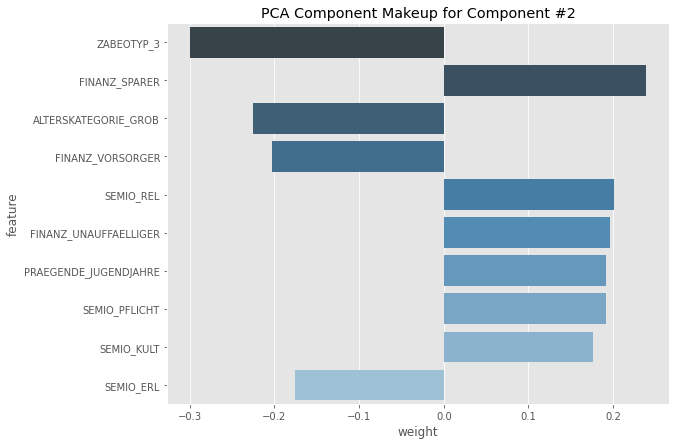

In [95]:
num = 2
display_component(w_df, features_list, num, n_weights=10)

In [32]:
# transform germany and customer data
germany_pca_data = pca.transform(germany_scaled_df)

In [33]:
germany_pca_data.shape

(616864, 152)

In [34]:
customers_pca_data = pca.transform(customers_scaled_df)

In [35]:
customers_pca_data.shape

(114703, 152)

In [97]:
obs = len(germany_pca_data)
distances = []
for k in range(1, 10):
    print('k = {}'.format(k))
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(germany_pca_data)
    distances.append(kmeans.inertia_/obs)

k = 1
k = 2
k = 3
k = 4
k = 5
k = 6
k = 7
k = 8
k = 9


Text(0.5, 1.0, 'Elbow curve')

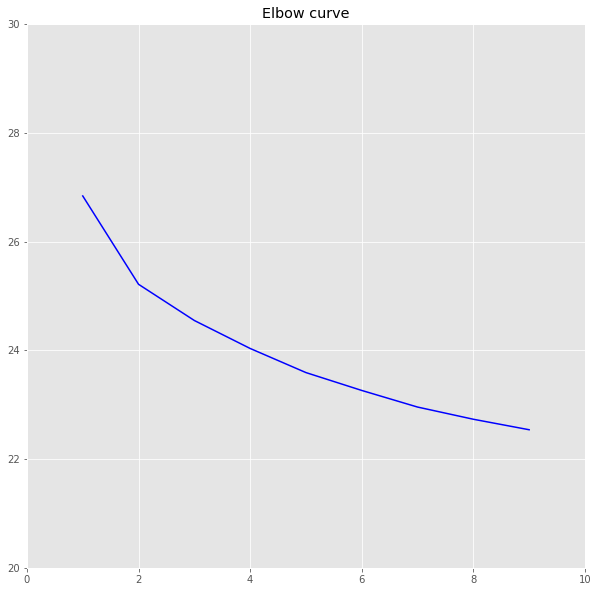

In [99]:
fig = plt.figure(figsize=(10, 10))
plt.plot(range(1,10), distances, color='blue')
plt.xlim(0, 10)
plt.ylim(20,30)
plt.grid(True)
plt.title('Elbow curve')

In [100]:
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(germany_pca_data)

KMeans(n_clusters=2)

In [101]:
germany_pred = kmeans.predict(germany_pca_data)
customers_pred = kmeans.predict(customers_pca_data)
print(len(germany_pred))
print(len(customers_pred))

616864
114703


In [102]:
germany_pred_df = pd.DataFrame(germany_pred)
germany_values = germany_pred_df[0].value_counts().sort_index()
customers_pred_df = pd.DataFrame(customers_pred)
customers_values = customers_pred_df[0].value_counts().sort_index()

In [103]:
germany_pred_df.head()

,0
0,1
1,0
2,0
3,0
4,1


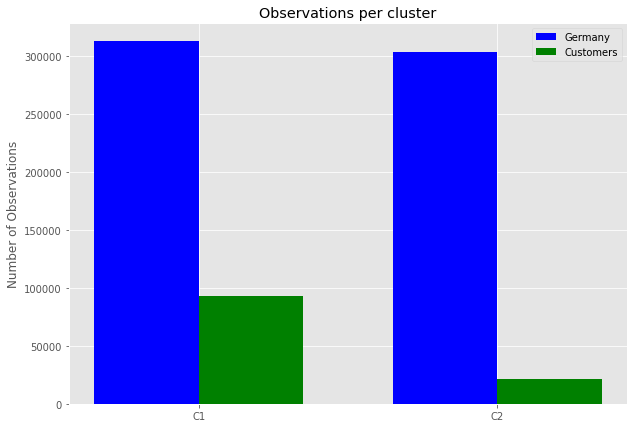

In [104]:
x = np.arange(k)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(x - width/2, germany_values.values, width, label='Germany', color='blue')
rects2 = ax.bar(x + width/2, customers_values.values, width, label='Customers', color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
labels = ['C{}'.format(ix + 1) for ix in np.arange(k)]
ax.set_ylabel('Number of Observations')
ax.set_title('Observations per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

Text(0.5, 1.0, 'Ratio of Customers/Germany data for each cluster')

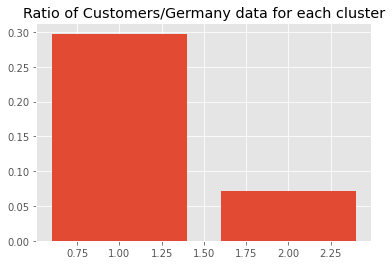

In [105]:
perc = customers_values.values/germany_values.values
plt.bar(range(1,k+1), perc)
plt.title('Ratio of Customers/Germany data for each cluster')

In [106]:
kmeans_df = pd.DataFrame(kmeans.cluster_centers_, columns = ['comp_{}'.format(i) for i in range(1,153)])
kmeans_df

,comp_1,comp_2,comp_3,comp_4,comp_5,comp_6,comp_7,comp_8,comp_9,comp_10,...,comp_143,comp_144,comp_145,comp_146,comp_147,comp_148,comp_149,comp_150,comp_151,comp_152
0,1.238042,-0.177513,-0.008615,-0.022843,-0.048911,0.030935,0.016144,-0.019799,-0.012398,-0.001027,...,0.002787,-0.001775,0.001593,0.001326,0.000694,0.000344,-0.000698,-0.001501,0.000051,0.001686
1,-1.275216,0.182843,0.008874,0.023528,0.050380,-0.031864,-0.016629,0.020393,0.012771,0.001058,...,-0.002871,0.001828,-0.001641,-0.001366,-0.000715,-0.000354,0.000719,0.001546,-0.000053,-0.001737


Text(0.5, 1.0, 'Cluster Makeup')

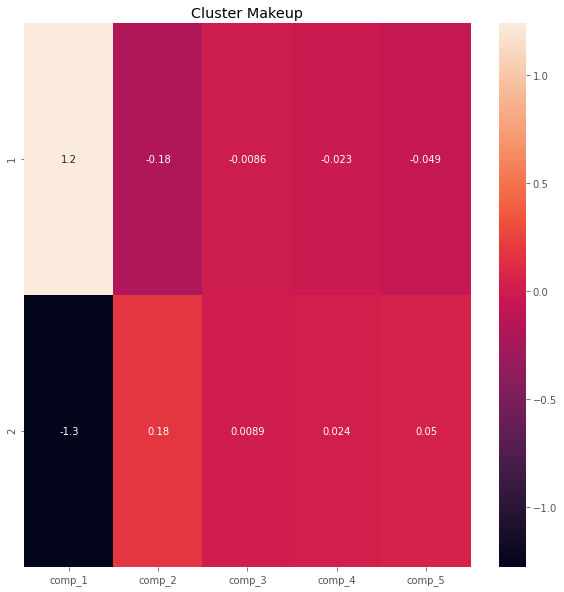

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(kmeans_df.iloc[0:13, 0:5], annot=True)
#sns.heatmap(kmeans_df, annot=True)
ax.set_yticklabels(np.arange(1,14))
plt.title('Cluster Makeup')

In [ ]:
train_df = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
test_df = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
print(train_df.shape)
print(test_df.shape)

In [ ]:
metadata = pd.read_csv('data/metadata.csv')
test_df['RESPONSE'] = 0
if 'RESPONSE' not in list(metadata['feature_name']):
    response = {
        'feature_name': 'RESPONSE',
        'type': 'ordinal', 
        'unknown_neg_one': 0,
        'unknown_zero': 0,
        'unknown_nine': 0,
        'zero_none': 0,
        'needs_reverse': 0,
        'keep': 1
    }
    metadata = metadata.append(response, ignore_index=True)
metadata[metadata['feature_name'] == 'RESPONSE']

clean_train = clean_data_part_one(train_df, metadata)
clean_test = clean_data_part_one(test_df, metadata)

In [ ]:
percent_missing = clean_train.isnull().sum() * 100 / len(clean_train)
missing_value_df = pd.DataFrame({'column_name': clean_train.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

f, ax = plt.subplots(figsize=(11,8))
plt.bar(missing_value_df['column_name'], missing_value_df['percent_missing'], label={}, color='blue')
plt.xticks([])
plt.title('Percentage of missing values per each feature (Germany Data)')

In [ ]:
percent_missing = clean_test.isnull().sum() * 100 / len(clean_test)
missing_value_df = pd.DataFrame({'column_name': clean_test.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)

f, ax = plt.subplots(figsize=(11,8))
plt.bar(missing_value_df['column_name'], missing_value_df['percent_missing'], label={}, color='blue')
plt.xticks([])
plt.title('Percentage of missing values per each feature (Germany Data)')

In [ ]:
clean_train = clean_data_part_two(clean_train, metadata, drop_threshold=23)
clean_test = clean_data_part_two(clean_test, metadata, drop_threshold=23)
print(clean_train.shape)
print(clean_test.shape)

In [ ]:
train_cols = set(clean_train.columns)
test_cols = set(clean_test.columns)
intersection = set.intersection(train_cols, test_cols)

clean_train = clean_train[list(intersection)]
clean_test = clean_test[list(intersection)]
assert(sorted(list(clean_train.columns)) == sorted(list(clean_test.columns)))

print(clean_train.shape)
print(clean_test.shape)

In [ ]:
y = clean_train['RESPONSE']
X = clean_train.drop('RESPONSE', axis=1)

In [ ]:
scaler = MinMaxScaler()
train_scaled_df = pd.DataFrame(scaler.fit_transform(X.astype(float)))
print(train_scaled_df.shape)

In [ ]:
NUM_COMPONENTS = 174
pca = PCA(n_components=NUM_COMPONENTS)
pca.fit(train_scaled_df)
print(np.sum(pca.explained_variance_ratio_))

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [ ]:
scaler = MinMaxScaler()
train_scaled_df = pd.DataFrame(scaler.fit_transform(X_train.astype(float)))
print(train_scaled_df.shape)

validation_scaled_df = pd.DataFrame(scaler.fit_transform(X_test.astype(float)))
print(validation_scaled_df.shape)

In [ ]:
pca_train = pca.transform(train_scaled_df)
pca_validation = pca.transform(validation_scaled_df)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf = LogisticRegression(penalty='l2', random_state=0)
clf.fit(pca_train, y_train)

In [ ]:
clf.score(pca_train, y_train)

In [ ]:
clf.score(pca_validation, y_test)

In [ ]:
y_pred = clf.predict(pca_validation)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
y_test.value_counts()

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
oversample = SMOTE()
train_smote_X, train_smote_y = oversample.fit_resample(X_train, y_train)

In [ ]:
print(train_smote_X.shape)
print(train_smote_y.shape)

In [ ]:
train_smote_y.value_counts()

In [ ]:
clf = LogisticRegression(penalty='l2', random_state=0)
clf.fit(train_smote_X, train_smote_y)

In [ ]:
print(clf.score(pca_validation, y_test))
y_pred = clf.predict(pca_validation)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
THRESHOLD = 0.60
preds = np.where(clf.predict_proba(pca_validation)[:,1] > THRESHOLD, 1, 0)
confusion_matrix(y_test, preds)

In [ ]:
y_test.value_counts()

In [ ]:
y_train.value_counts()

In [ ]:
 tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print('true positives: ', tp)
print('false negatives: ', fn)
print('false_positives: ', fp)
print('true negatives: ', tn)

In [ ]:
from imblearn.over_sampling import ADASYN
oversample = ADASYN()
train_adasyn_X, train_adasyn_y = oversample.fit_resample(pca_train, y_train)

In [ ]:
clf = LogisticRegression(penalty='l2', random_state=0)
clf.fit(train_adasyn_X, train_adasyn_y)

In [ ]:
THRESHOLD = 0.50
preds = np.where(clf.predict_proba(pca_test)[:,1] > THRESHOLD, 1, 0)
confusion_matrix(y_test, preds)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_test, preds)

In [ ]:
import xgboost as xgb

In [ ]:
y = clean_train['RESPONSE']
X = clean_train.drop('RESPONSE', axis=1)

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [ ]:
oversample = SMOTE()
train_smote_X, train_smote_y = oversample.fit_resample(X_train, y_train)

In [ ]:
params = {'max_depth': 1, 'eta': 0.01, 'objective': 'binary:logistic', 'eval_metric': 'rmse', 'alpha': 10, 
          'lambda': 5, 'n_estimators':5}

In [ ]:
xg_clf = xgb.XGBClassifier(**params)

In [ ]:
xg_clf.fit(train_smote_X, train_smote_y)

In [ ]:
preds = xg_clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_test, preds)

In [ ]:
confusion_matrix(y_test, preds)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_test, preds)